In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import f1_score
from scipy.stats import gaussian_kde
from scipy.integrate import quad

# Extended Figure 1: F1-scores barplots

In [102]:
predsdat = ['BLC_LeeHCRESULTS.csv', 'BLC_LeeCovRESULTS.csv', 'BLC_OelenRESULTS.csv', 'BLC_SmartSeq3RESULTS.csv']
resdat = ['scType_LeeHCRESULTS.csv', 'scType_LeeCovRESULTS.csv', 'scType_OelenRESULTS.csv', 'scType_SmartSeq3RESULTS.csv']
scpredat = ['scPred_LeeHCRESULTS.csv', 'scPred_LeeCovRESULTS.csv', 'scPred_OelenRESULTS.csv', 'scPred_SmartSeq3RESULTS.csv']

datsetnames = ['Lee et al HC', 'Lee et al Covid', 'Oelen et al', 'SmartSeq']

scpreds_f1s = pd.DataFrame()
blc_f1s = pd.DataFrame()
sctype_f1s = pd.DataFrame()


for i in range(4):
    print(i)
    data_sctype = '../../classifiers_results/test_data/' + str(resdat[i])
    res = pd.read_csv(data_sctype, sep = ';')
    res['ct_pred'] = res['customclassif'].copy()
    #res = res.rename(columns = {'customclassif':'ct_pred'})
    ct_dic = {'Naive B cells':'B', 'Pre-B cells':'B',  'Plasmacytoid Dendritic cells': 'pDC', 'Non-classical monocytes':'Non-classical Monocyte', 'Natural killer  cells':'NK', 'Naive CD4+ T cells': 'CD4T', 'CD8+ NKT-like cells':'CD8T', 'Classical Monocytes':'Classical Monocyte', 'Platelets':'Platelet', 'Myeloid Dendritic cells': 'DC', 'γδ-T cells':'γδ-T cells', 
              'Effector CD8+ T cells':'CD8T', 'Memory CD4+ T cells': 'CD4T', 'Naive CD8+ T cells': 'CD8T', 'Effector CD4+ T cells':'CD4T', 'Memory CD8+ T cells':'CD8T', 
             'ISG expressing immune cells':'ISGs', 'Memory B cells':'B', 'Macrophages':'Macrophages', 'Megakaryocyte':'Megakaryocyte', 'Plasma B cells':'Plasma B', 'Progenitor cells': 'Progenitor cells', 'Erythroid-like and erythroid precursor cells': 'Erythroid-like and erythroid precursor cells',
             'Basophils':'Basophils', 'Neutrophils':'Neutrophil', 'Granulocytes':'Granulocytes', 'HSC/MPP cells':'HSC/MPP cells', 'Unknown':'Unknown', 'Erythroid-like and erythroid precursor cells':'Erythrocyte'}

    res['ct_pred'] = res['ct_pred'].apply(lambda x: ct_dic[x])
    res.ct_pred = res.ct_pred.astype(str)
    res.CellType = res.CellType.astype(str)
    
    #For "Macrophages" - set it to their original CellType
    inds = res[res.ct_pred == 'Macrophages'].index
    res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']

    #For "ISGs" - set it to their original CellType
    inds = res[res.ct_pred == 'ISGs'].index
    res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']

    preds = pd.read_csv('../../classifiers_results/test_data/' + str(predsdat[i]))
    preds['label'] = preds.ct_pred.values
    preds['actual_ct'] = preds.CellType.values

    scpred = pd.read_csv('../../classifiers_results/test_data/' + str(scpredat[i]), sep = ';')
    scpred['ct_pred'] = scpred.scpred_no_rejection.copy()

    
    
    temp = pd.DataFrame({'f1_score_micro': np.round(f1_score(scpred.ct_pred, scpred.CellType, average = 'micro'),2), 'f1_score_macro':np.round(f1_score(scpred.ct_pred, scpred.CellType, average = 'macro'),2), 'dataset':datsetnames[i], 'method':'scPred'}, index = [i])
    scpreds_f1s = pd.concat([temp, scpreds_f1s])
    temp = pd.DataFrame({'f1_score_micro': np.round(f1_score(res.ct_pred, res.CellType, average = 'micro'),2), 'f1_score_macro':np.round(f1_score(res.ct_pred, res.CellType, average = 'macro'),2), 'dataset':datsetnames[i], 'method':'scType'}, index = [i])
    sctype_f1s = pd.concat([temp, sctype_f1s])
    
    temp = pd.DataFrame({'f1_score_micro': np.round(f1_score(preds.ct_pred, preds.CellType, average = 'micro'),2), 'f1_score_macro':np.round(f1_score(preds.ct_pred, preds.CellType, average = 'macro'),2), 'dataset':datsetnames[i], 'method':'BLC'}, index = [i])
    blc_f1s = pd.concat([temp, blc_f1s])
    


0
1
2
3


In [103]:
all_f1s = pd.concat([blc_f1s, sctype_f1s, scpreds_f1s])

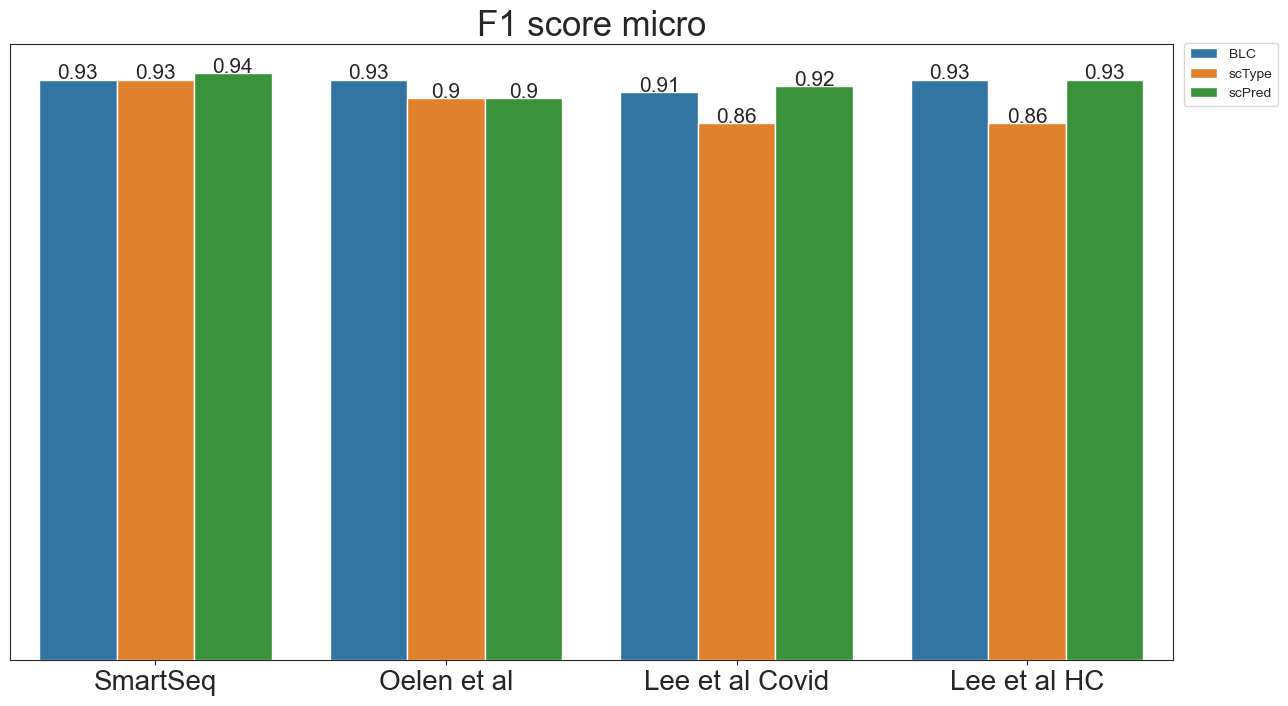

In [104]:
fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(all_f1s, x = 'dataset', y = 'f1_score_micro', hue = 'method')
# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2, h+0.001)
    text = np.round(h,2)
    ax.annotate(text=text, xy=xy, ha='center', va='baseline', size = 15)
    
#plt.yticks(fontsize = 15)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = True, bottom = True) 
plt.title('F1 score micro', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize = 20)
plt.legend(loc = (1.01,0.9))

#plt.savefig('F1_scores_micro_all.svg', bbox_inches = 'tight', dpi = 200)

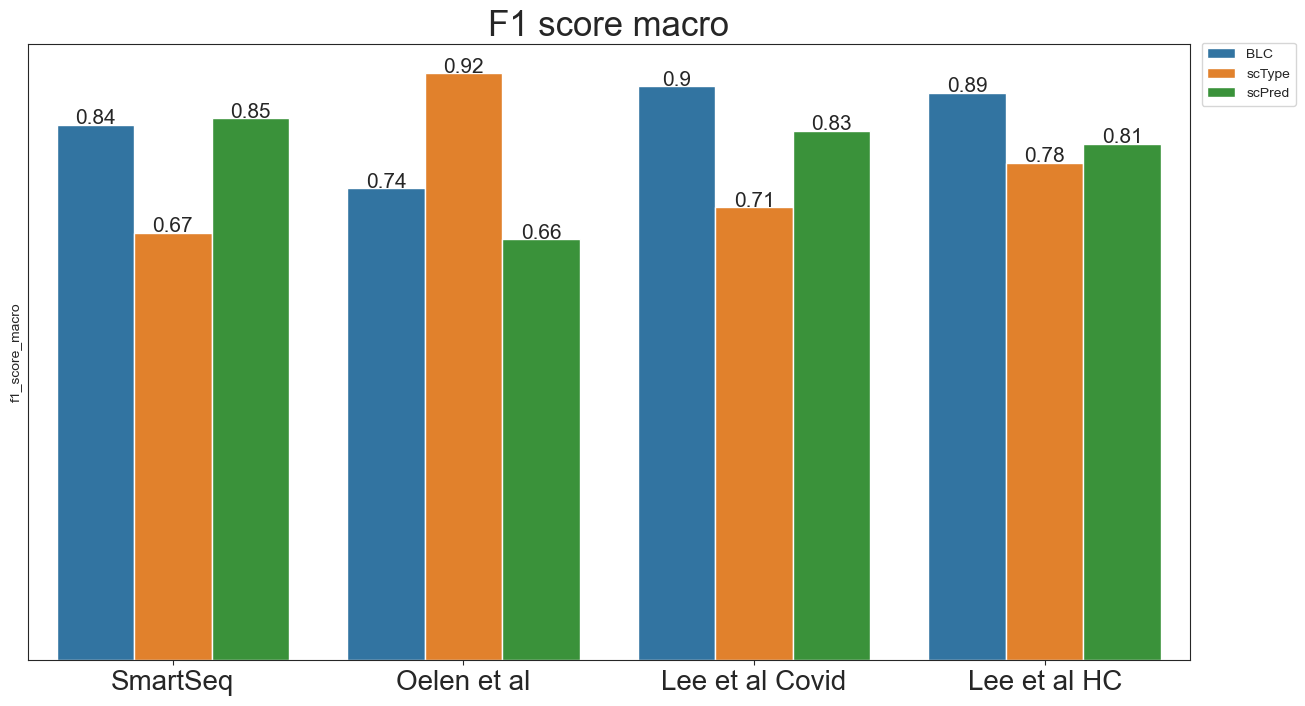

In [98]:
fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(all_f1s, x = 'dataset', y = 'f1_score_macro', hue = 'method')
# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2, h+0.001)
    text = np.round(h,2)
    ax.annotate(text=text, xy=xy, ha='center', va='baseline', size = 15)
    
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = True, bottom = True) 
plt.title('F1 score macro', fontsize = 25)
plt.xlabel('')
plt.xticks(fontsize = 20)
plt.legend(loc = (1.01,0.9))
#plt.savefig('F1_scores_macro_all.svg', bbox_inches = 'tight', dpi = 200)

# Extended Figure 2 - original annotations

In [53]:
#Smartseq
preds_smartseq = pd.read_csv('../../classifiers_results/test_data/BLC_SmartSeq3RESULTS.csv')

#Lee HC
preds_leehc = pd.read_csv('../../classifiers_results/test_data/BLC_LeeHCRESULTS.csv')

#Lee Covid
preds_leecov = pd.read_csv('../../classifiers_results/test_data/BLC_LeeCovRESULTS.csv')

#Oelen:
preds_3htb = pd.read_csv('../../classifiers_results/test_data/BLC_OelenRESULTS.csv')


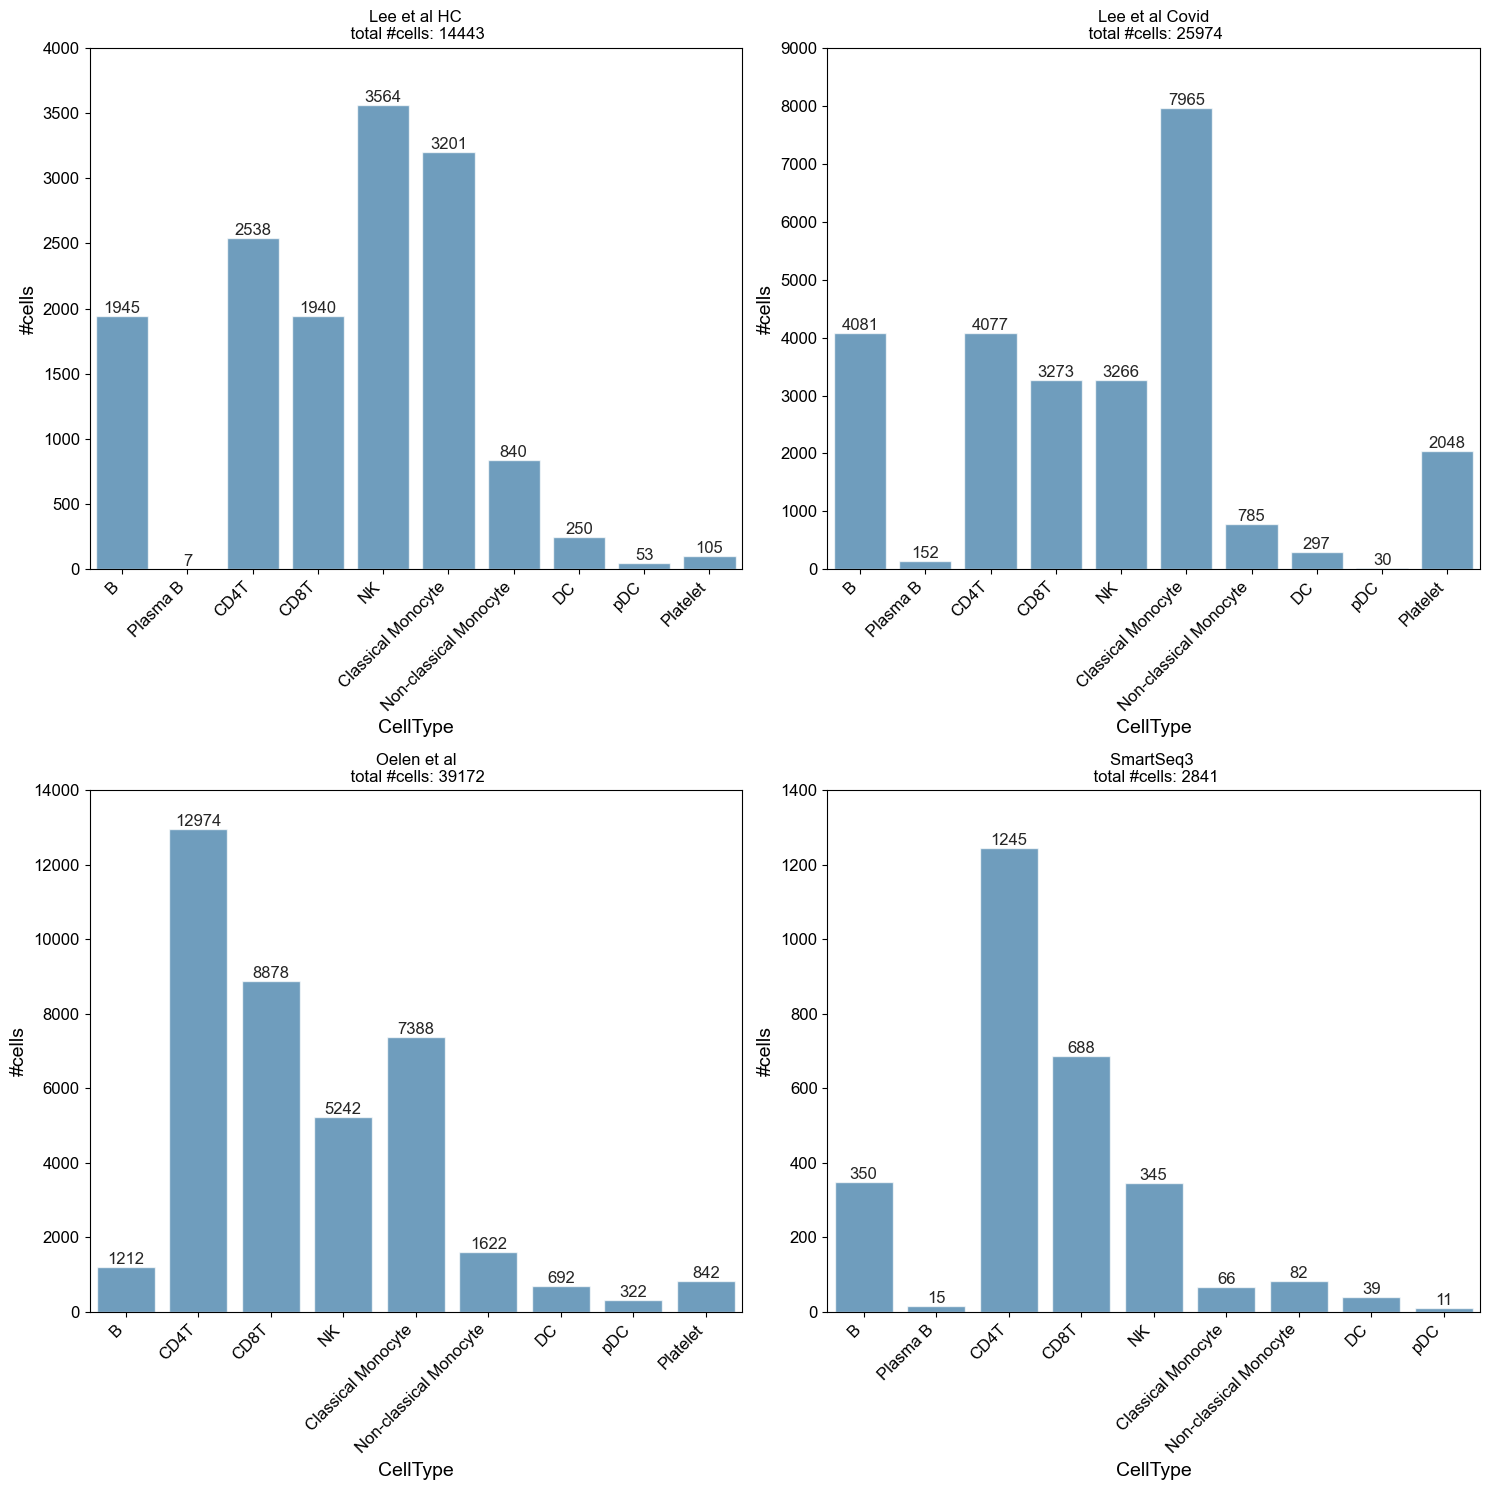

In [54]:
fig, ax = plt.subplots(2,2,figsize = (15,15))
ax = ax.flatten()
sns.set_style("ticks")

potential_actual_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Erythrocyte']
original_cts = list(set(preds_leehc.CellType))
actual_classes = []
for ct in potential_actual_classes:
    if ct in original_cts:
        actual_classes += [ct]

        
cthcgroup = preds_leehc.groupby('CellType').size()
cthcgroup = cthcgroup.loc[actual_classes]
cthcgroup = cthcgroup.reset_index()
cthcgroup.columns = ['CellType', '#cells']

potential_actual_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Erythrocyte']
original_cts = list(set(preds_leecov.CellType))
actual_classes = []
for ct in potential_actual_classes:
    if ct in original_cts:
        actual_classes += [ct]

        
if len(actual_classes) != len(original_cts):
    print("Not all CTs are included")
    
ctcovgroup = preds_leecov.groupby('CellType').size()
ctcovgroup = ctcovgroup.loc[actual_classes]
ctcovgroup = ctcovgroup.reset_index()
ctcovgroup.columns = ['CellType', '#cells']

potential_actual_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Erythrocyte']
original_cts = list(set(preds_3htb.CellType))
actual_classes = []
for ct in potential_actual_classes:
    if ct in original_cts:
        actual_classes += [ct]
        
ctstimgroup = preds_3htb.groupby('CellType').size()
ctstimgroup = ctstimgroup.loc[actual_classes]
ctstimgroup = ctstimgroup.reset_index()
ctstimgroup.columns = ['CellType', '#cells']

potential_actual_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Erythrocyte']
original_cts = list(set(preds_smartseq.CellType))
actual_classes = []
for ct in potential_actual_classes:
    if ct in original_cts:
        actual_classes += [ct]
        
ctgsegroup = preds_smartseq.groupby('CellType').size()
ctgsegroup = ctgsegroup.loc[actual_classes]
ctgsegroup = ctgsegroup.reset_index()
ctgsegroup.columns = ['CellType', '#cells']



sns.barplot(x = cthcgroup.CellType, y = cthcgroup['#cells'], ax = ax[0], color = 'tab:blue', alpha = 0.7)
sns.barplot(x = ctcovgroup.CellType, y = ctcovgroup['#cells'], ax = ax[1], color = 'tab:blue', alpha = 0.7)
sns.barplot(x = ctstimgroup.CellType, y = ctstimgroup['#cells'], ax = ax[2], color = 'tab:blue', alpha = 0.7)
sns.barplot(x = ctgsegroup.CellType, y = ctgsegroup['#cells'], ax = ax[3], color = 'tab:blue', alpha = 0.7)
#ax[0].set_xticks(labels = ax[0].get_xticklabels(), rotation = 45)

for index, value in enumerate(cthcgroup['#cells']):
    ax[0].text(index, value, str(value), ha='center', va='bottom', fontsize = 12)
    
for index, value in enumerate(ctcovgroup['#cells']):
    ax[1].text(index, value, str(value), ha='center', va='bottom', fontsize = 12)
    
for index, value in enumerate(ctstimgroup['#cells']):
    ax[2].text(index, value, str(value), ha='center', va='bottom', fontsize = 12)
    
for index, value in enumerate(ctgsegroup['#cells']):
    ax[3].text(index, value, str(value), ha='center', va='bottom', fontsize = 12)
    
ax[0].set_xticks(ax[0].get_xticks(), ax[0].get_xticklabels(), rotation=45, ha='right', fontsize = 12)
ax[1].set_xticks(ax[1].get_xticks(), ax[1].get_xticklabels(), rotation=45, ha='right', fontsize = 12)
ax[2].set_xticks(ax[2].get_xticks(), ax[2].get_xticklabels(), rotation=45, ha='right', fontsize = 12)
ax[3].set_xticks(ax[3].get_xticks(), ax[3].get_xticklabels(), rotation=45, ha='right', fontsize = 12)

ax[0].set_yticks(ax[0].get_yticks(), ax[0].get_yticklabels(), fontsize = 12)
ax[1].set_yticks(ax[1].get_yticks(), ax[1].get_yticklabels(), fontsize = 12)
ax[2].set_yticks(ax[2].get_yticks(), ax[2].get_yticklabels(), fontsize = 12)
ax[3].set_yticks(ax[3].get_yticks(), ax[3].get_yticklabels(), fontsize = 12)

ax[0].set_title('Lee et al HC\n total #cells: ' + str(len(preds_leehc)))
ax[1].set_title('Lee et al Covid\n total #cells: ' + str(len(preds_leecov)))
ax[2].set_title('Oelen et al\n total #cells: ' + str(len(preds_3htb)))
#ax[3].set_title('Hagemann-Jensen et al\n total #cells: ' + str(len(preds_smartseq)))
ax[3].set_title('SmartSeq3 \n total #cells: ' + str(len(preds_smartseq)))

ax[0].set_ylabel("#cells", fontsize = 14)
ax[0].set_xlabel("CellType", fontsize = 14)

ax[1].set_ylabel("#cells", fontsize = 14)
ax[1].set_xlabel("CellType", fontsize = 14)

ax[2].set_ylabel("#cells", fontsize = 14)
ax[2].set_xlabel("CellType", fontsize = 14)

ax[3].set_ylabel("#cells", fontsize = 14)
ax[3].set_xlabel("CellType", fontsize = 14)

plt.tight_layout()
#plt.savefig('cells_per_celltype_Lee_EGAD3hTBstim_SmartSeq3.svg', bbox_inches = 'tight', format = 'svg', dpi = 200)

# Extended Figure 3A and B

/var/folders/vm/qd7pm6ts2lggn9n80c60p4sr0000gn/T/ipykernel_63654/1994653565.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blc_ctpreds['seperate_ctpred'] = 'X'
/var/folders/vm/qd7pm6ts2lggn9n80c60p4sr0000gn/T/ipykernel_63654/1994653565.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blc_ctpreds.loc[blc_ctpreds[blc_ctpreds.index.isin(predsh.index)].index, 'seperate_ctpred'] = predsh.loc[blc_ctpreds[blc_ctpreds.index.isin(predsh.index)].index, 'ct_pred']
/var/folders/vm/qd7pm6ts2lggn9n80c60p4sr0000gn/T/ipykernel_63654/1994653565.py:17: SettingWithCopyWar

Text(0.5, 1.0, 'Likelihood vs First runner up in inconsistent annotations\ncomparing mergead vs separate annotation of datasets')

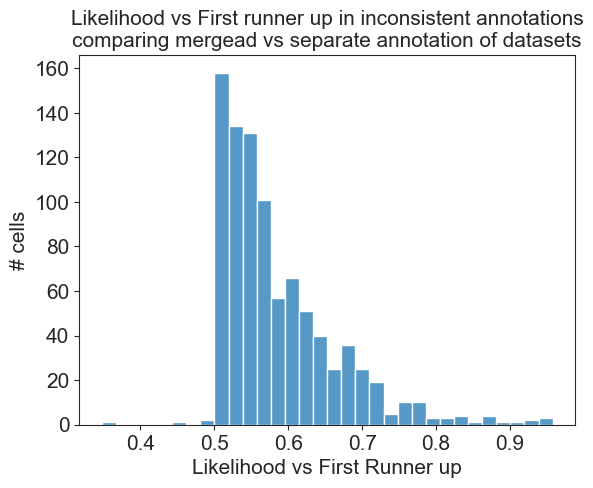

In [55]:
#Lee HC and Covid
predsb = pd.read_csv('../../classifiers_results/test_data/BLC_LeeCovHCRESULTS.csv')

#Lee HC
predsh = pd.read_csv('../../classifiers_results/test_data/BLC_LeeHCRESULTS.csv')

#Lee Covid
predsc = pd.read_csv('../../classifiers_results/test_data/BLC_LeeCovRESULTS.csv')

predsb = predsb.set_index('Unnamed: 0')
predsh = predsh.set_index('Unnamed: 0')
predsc = predsc.set_index('Unnamed: 0')

blc_ctpreds = predsb[['ct_pred']]
blc_ctpreds['seperate_ctpred'] = 'X'
blc_ctpreds.loc[blc_ctpreds[blc_ctpreds.index.isin(predsh.index)].index, 'seperate_ctpred'] = predsh.loc[blc_ctpreds[blc_ctpreds.index.isin(predsh.index)].index, 'ct_pred']
blc_ctpreds.loc[blc_ctpreds[blc_ctpreds.index.isin(predsc.index)].index, 'seperate_ctpred'] = predsc.loc[blc_ctpreds[blc_ctpreds.index.isin(predsc.index)].index, 'ct_pred']

blc_mismatch = len(blc_ctpreds[blc_ctpreds.ct_pred != blc_ctpreds.seperate_ctpred])/len(blc_ctpreds)
barplot_blc_mismatch = pd.DataFrame(blc_ctpreds[blc_ctpreds.ct_pred != blc_ctpreds.seperate_ctpred].groupby('ct_pred').size())
barplot_blc_mismatch.loc['pDC'] = 0 #No pDCs were wrong
wind = blc_ctpreds[blc_ctpreds.ct_pred != blc_ctpreds.seperate_ctpred].index
sns.histplot(predsb.loc[predsb.index.isin(wind)]['likelihood_vs_second_ct'])

plt.xlabel('Likelihood vs First Runner up', fontsize = 15)
plt.ylabel('# cells', fontsize = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.title('Likelihood vs First runner up in inconsistent annotations\ncomparing mergead vs separate annotation of datasets', size = 15)

In [56]:
cts=predsb.loc[wind].second_most_likely

In [57]:
blc_ctpreds2 = blc_ctpreds.loc[wind]

In [58]:
blc_ctpreds2['second_most_likely'] = cts.values

In [59]:
barplot = pd.DataFrame({'in runner-ups':1-(len(blc_ctpreds2[blc_ctpreds2.seperate_ctpred != blc_ctpreds2.second_most_likely])/len(blc_ctpreds2)), 'not in runner-ups': len(blc_ctpreds2[blc_ctpreds2.seperate_ctpred != blc_ctpreds2.second_most_likely])/len(blc_ctpreds2)}, index = [0])

In [60]:
barplot = barplot*100

Text(0.5, 1.0, 'Coherent annotations found in runner ups\n for incoherent annotations')

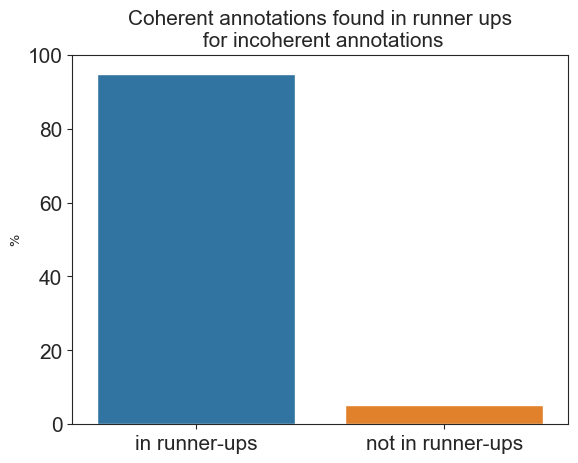

In [62]:
sns.barplot(barplot)
plt.xticks(size = 15)
plt.yticks(ticks=[0,20,40,60,80,100], size = 15)
plt.ylabel('%')
plt.title('Coherent annotations found in runner ups\n for incoherent annotations', size = 15)

#plt.savefig('cts_in_runnerups.svg', dpi = 200)


# Extended Figure3c) - heatmap of Lee et al Covid and HC together

In [63]:
def make_heatmap_f1_score_without_scpred(preds, res, savestr, dataset_title, save = False, average_f1 = 'weighted'):
    fig, ax = plt.subplots(1,2, figsize = (20,10))
    ax=ax.flatten()
    
    label_dictionary= {'B':'B', 'Plasma B': 'Plasma B', 'CD4T':'CD4T', 'CD8T':'CD8T', 'NK':'NK', 'Classical Monocyte':'CM', 'Non-classical Monocyte':'nCM', 'DC':'DC', 'pDC':'pDC', 'Erythrocyte':'RBC', 'Platelet':'Platelet', 'Neutrophil':'Neutrophil', 'Granulocyte':'Granulocyte', 'Granulocytes':'Granulocyte',
                      'γδ-T cells':'γδ-T cells', 'Progenitor cells':'Progenitor cells', 'HSC/MPP cells':'HSC/MPP cells'}
    
    cmap_chosen = 'Blues'

    potential_actual_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Erythrocyte', 'Granulocytes']
    original_cts = list(set(res.CellType))
    actual_classes = []
    for ct in potential_actual_classes:
        if ct in original_cts:
            actual_classes += [ct]

    potential_prediction_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Erythrocyte', 'Granulocytes']
    prediction_classes = []
    original_predictions = list(set(preds.ct_pred))

    for ct in potential_prediction_classes:
        if ct in original_predictions:
            prediction_classes += [ct]

    if len(list(set(prediction_classes))) == len(original_predictions):
        print("Prediction classes OK BLC")
    else:
        prediction_classes = []

    if len(list(set(actual_classes))) == len(original_cts):
        print("Actual classes OK")
    else:
        actual_classes = []

    #BLC

    actual_labels = preds.CellType
    predicted_labels = preds.ct_pred

    conf_matrix = np.zeros((len(actual_classes), len(prediction_classes)))

    for i in range(len(actual_classes)):
        for j in range(len(prediction_classes)):
            conf_matrix[i, j] = np.sum((actual_labels==actual_classes[i]) & (predicted_labels == prediction_classes[j]) )

    conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1).reshape((-1, 1))
    conf_matrix = np.round(conf_matrix, 2)
    conf_matrix[conf_matrix < 0.01] = 0 #reduce noise in the heatmap
    
    mask = np.zeros_like(conf_matrix)
    mask[conf_matrix==0] = True
    sns.heatmap(conf_matrix, mask=mask, cmap = cmap_chosen, annot=True, annot_kws={"fontsize":18}, ax = ax[0], alpha = 0.9)

    labels_predictions = [label_dictionary[x] for x in prediction_classes]
    labels_actuals = [label_dictionary[x] for x in actual_classes]
    
    ax[0].set_xticks(ticks = np.arange(len(prediction_classes))+0.5, labels=labels_predictions, rotation = 45, ha = 'right', fontsize = 18)#, rotation_mode = 'anchor')
    ax[0].set_yticks(ticks = np.arange(len(actual_classes)) +0.5, labels=labels_actuals, rotation = 0, ha = 'right', rotation_mode = 'anchor', fontsize = 18)
    ax[0].set_xlabel('Predicted class', fontsize = 20)
    ax[0].set_ylabel('Actual class', fontsize = 20)
    f1 = f1_score(preds.ct_pred, preds.CellType, average = average_f1)
    f1 = str(np.round(f1, 2))

    ax[0].set_title('F1-score BLC: '+str(f1), fontsize = 22)


    ########################################################################

    #SCTYPE

    actual_labels = res.CellType
    predicted_labels = res.ct_pred
    #actual_classes = np.sort(list(set(actual_labels)))
    #prediction_classes = np.sort(list(set(predicted_labels)))
    #actual_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet']

    potential_prediction_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Granulocytes', 'ISGs', 'γδ-T cells', 'Progenitor cells', 'Erythrocyte', 'Unknown', 'HSC/MPP cells']
    prediction_classes = []
    original_predictions = list(set(res.ct_pred))
    for ct in potential_prediction_classes:
        if ct in original_predictions:
            prediction_classes += [ct]

    if len(list(set(prediction_classes))) == len(original_predictions):
        print("Prediction classes OK scType")
    else:
        print("Some predicted class not included")
        prediction_classes = []


    #prediction_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil']

    conf_matrix = np.zeros((len(actual_classes), len(prediction_classes)))

    for i in range(len(actual_classes)):
        for j in range(len(prediction_classes)):
            conf_matrix[i, j] = np.sum((actual_labels==actual_classes[i]) & (predicted_labels == prediction_classes[j]) )

    conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1).reshape((-1, 1))
    conf_matrix = np.round(conf_matrix, 2)
    conf_matrix[conf_matrix < 0.01] = 0 #reduce noise in the heatmap

    mask = np.zeros_like(conf_matrix)
    mask[conf_matrix==0] = True
    sns.heatmap(conf_matrix, mask=mask, cmap = cmap_chosen, annot=True, annot_kws={"fontsize":18}, ax = ax[1], alpha = 0.9)
    
    labels_predictions = [label_dictionary[x] for x in prediction_classes]
    labels_actuals = [label_dictionary[x] for x in actual_classes]
    
    ax[1].set_xticks(ticks = np.arange(len(prediction_classes))+0.5, labels=labels_predictions, rotation = 45, ha = 'right', fontsize = 18)#, rotation_mode = 'anchor')
    ax[1].set_yticks(ticks = np.arange(len(actual_classes)) +0.5, labels=labels_actuals, rotation = 0, ha = 'right', rotation_mode = 'anchor', fontsize = 18)
    ax[1].set_xlabel('Predicted class', fontsize = 20)
    ax[1].set_ylabel('Actual class', fontsize = 20)
    f1 = f1_score(res.ct_pred, res.CellType, average = average_f1)
    f1 = str(np.round(f1, 2))

    ax[1].set_title('F1-score scType: '+str(f1), fontsize = 22)
    
    ########################################################################
    plt.suptitle(dataset_title, fontsize = 30)
    plt.tight_layout()
    if save:
        plt.savefig('./' + savestr, format = 'svg', bbox_inches = 'tight', dpi = 300)

In [89]:
#Lee et al HC:
#BLC:
preds =  pd.read_csv('../../classifiers_results/test_data/BLC_LeeCovHCRESULTS.csv')

#ScType:
data_sctype = '../../classifiers_results/test_data/scType_LeeCovHCRESULTS.csv'

res = pd.read_csv(data_sctype, sep = ';')
res['ct_pred'] = res['customclassif'].copy()

ct_dic = {'Naive B cells':'B', 'Pre-B cells':'B',  'Plasmacytoid Dendritic cells': 'pDC', 'Non-classical monocytes':'Non-classical Monocyte', 'Natural killer  cells':'NK', 'Naive CD4+ T cells': 'CD4T', 'CD8+ NKT-like cells':'CD8T', 'Classical Monocytes':'Classical Monocyte', 'Platelets':'Platelet', 'Myeloid Dendritic cells': 'DC', 'γδ-T cells':'γδ-T cells', 
          'Effector CD8+ T cells':'CD8T', 'Memory CD4+ T cells': 'CD4T', 'Naive CD8+ T cells': 'CD8T', 'Effector CD4+ T cells':'CD4T', 'Memory CD8+ T cells':'CD8T', 
         'ISG expressing immune cells':'ISGs', 'Memory B cells':'B', 'Macrophages':'Macrophages', 'Megakaryocyte':'Megakaryocyte', 'Plasma B cells':'Plasma B', 'Progenitor cells': 'Progenitor cells', 'Erythroid-like and erythroid precursor cells': 'Erythroid-like and erythroid precursor cells',
         'Basophils':'Basophils', 'Neutrophils':'Neutrophil', 'Granulocytes':'Granulocytes', 'HSC/MPP cells':'HSC/MPP cells', 'Unknown':'Unknown', 'Erythroid-like and erythroid precursor cells':'Erythrocyte'}

res['ct_pred'] = res['ct_pred'].apply(lambda x: ct_dic[x])
res.ct_pred = res.ct_pred.astype(str)
res.CellType = res.CellType.astype(str)


#For "Macrophages" - set it to their original CellType
inds = res[res.ct_pred == 'Macrophages'].index
res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']

#For "ISGs" - set it to their original CellType
inds = res[res.ct_pred == 'ISGs'].index
res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']

Prediction classes OK BLC
Actual classes OK
Prediction classes OK scType


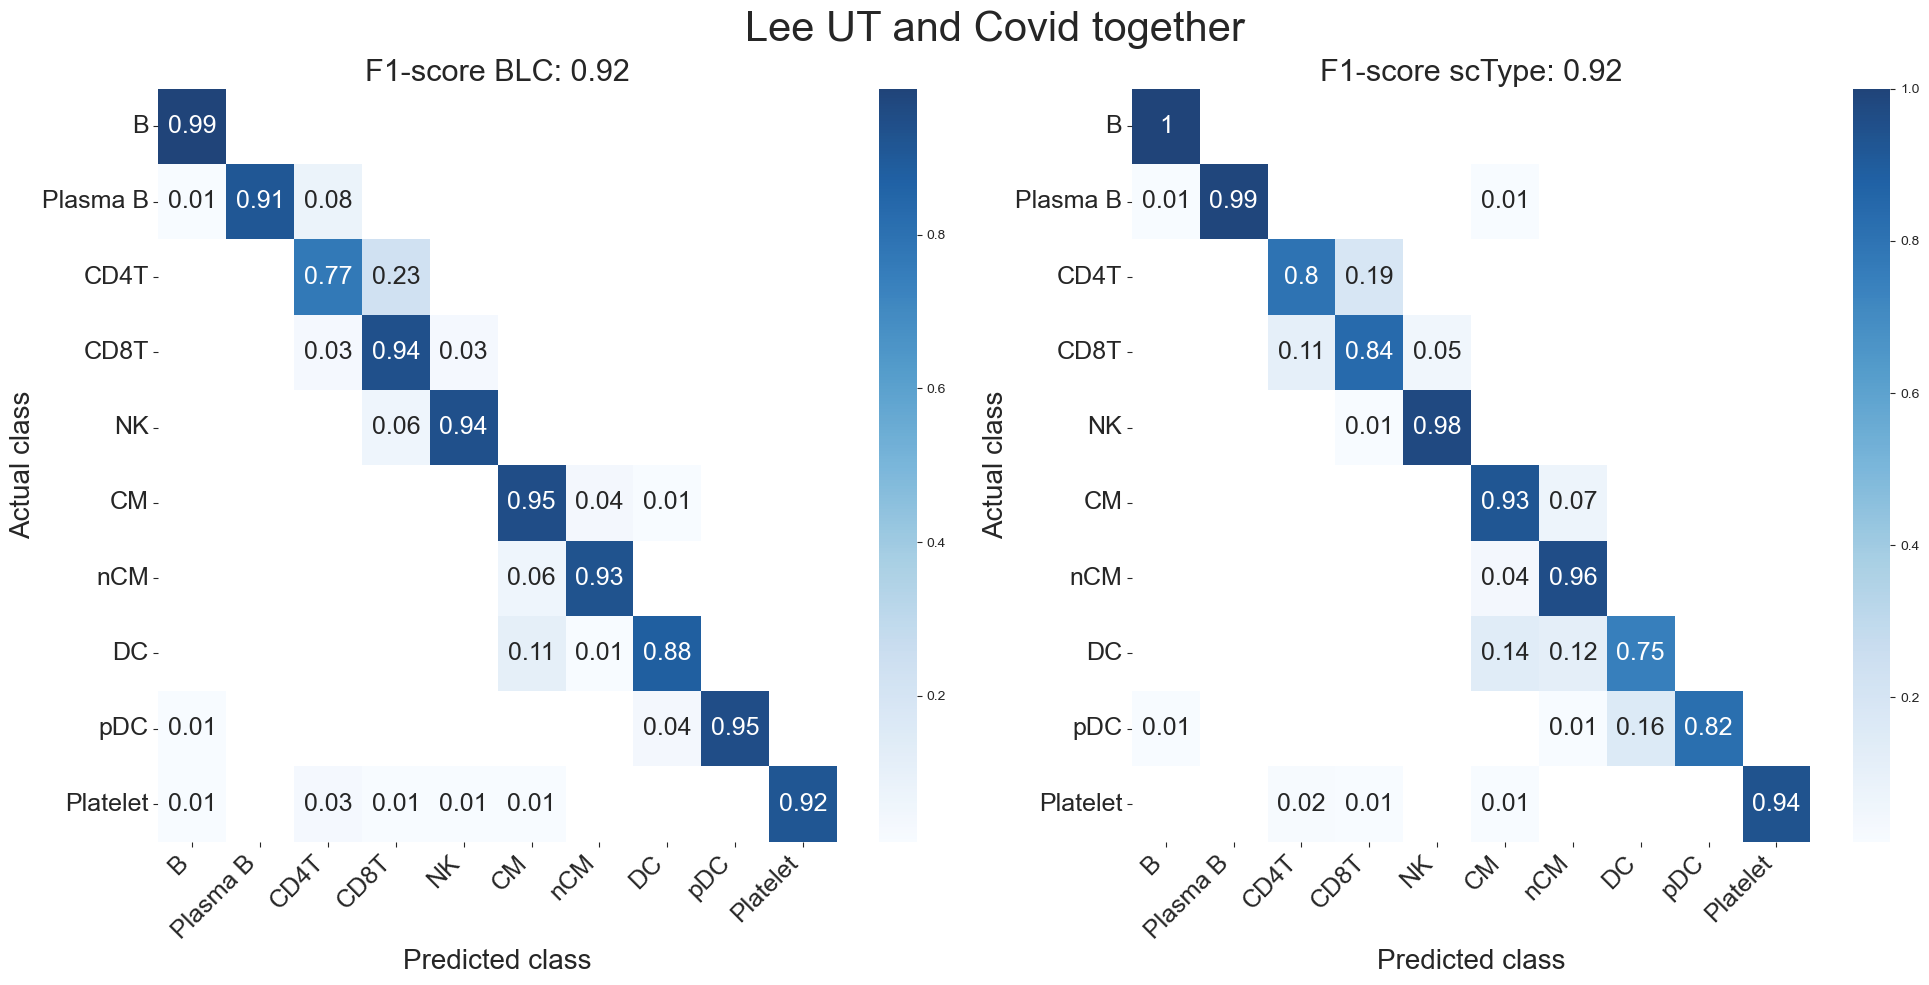

In [90]:
make_heatmap_f1_score_without_scpred(preds, res, dataset_title = 'Lee UT and Covid together', save = False, savestr = 'Extended_Figure3_LeeCovidAndHC.svg', average_f1 = 'micro')

# Extended Figure 4

## Extended Figure 4a: Certainty levels for scPred

In [11]:
#Lee et al combined Covid and HC:
preds_leehc = pd.read_csv('../../classifiers_results/test_data/scPred_LeeHCRESULTS.csv', sep = ';')
preds_leecov = pd.read_csv('../../classifiers_results/test_data/scPred_LeeCovRESULTS.csv', sep = ';')


#EGAD-3hTBstimulation severe only
preds_egad = pd.read_csv('../../classifiers_results/test_data/scPred_OelenRESULTS.csv', sep = ';')

#SmartSeq3
preds_smartseq = pd.read_csv('../../classifiers_results/test_data/scPred_SmartSeq3RESULTS.csv', sep = ';')


In [12]:
preds = pd.concat([preds_leehc, preds_leecov, preds_egad, preds_smartseq])

In [13]:
tt = preds[preds.scpred_no_rejection == preds.CellType]

In [14]:
tt['scpred_max'] = [float(x.replace(',', '.')) for x in tt.scpred_max]

/var/folders/vm/qd7pm6ts2lggn9n80c60p4sr0000gn/T/ipykernel_63654/1647166538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['scpred_max'] = [float(x.replace(',', '.')) for x in tt.scpred_max]


In [16]:
preds['scpred_max'] = [float(x.replace(',', '.')) for x in preds.scpred_max]

In [17]:
preds = pd.concat([preds_leehc, preds_leecov, preds_egad, preds_smartseq])
preds['scpred_max'] = [float(x.replace(',', '.')) for x in preds.scpred_max]
preds['scpred_max'] = np.round(preds.scpred_max, 2)

/var/folders/vm/qd7pm6ts2lggn9n80c60p4sr0000gn/T/ipykernel_63654/784360203.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), size = 14)
/var/folders/vm/qd7pm6ts2lggn9n80c60p4sr0000gn/T/ipykernel_63654/784360203.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), size = 14)
/var/folders/vm/qd7pm6ts2lggn9n80c60p4sr0000gn/T/ipykernel_63654/784360203.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticklabels(), size = 14)
/var/folders/vm/qd7pm6ts2lggn9n80c60p4sr0000gn/T/ipykernel_63654/784360203.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ax[1].get_yticklabels(), size = 14)


[Text(0, 0.0, '0'),
 Text(0, 200.0, '200'),
 Text(0, 400.0, '400'),
 Text(0, 600.0, '600'),
 Text(0, 800.0, '800'),
 Text(0, 1000.0, '1000'),
 Text(0, 1200.0, '1200')]

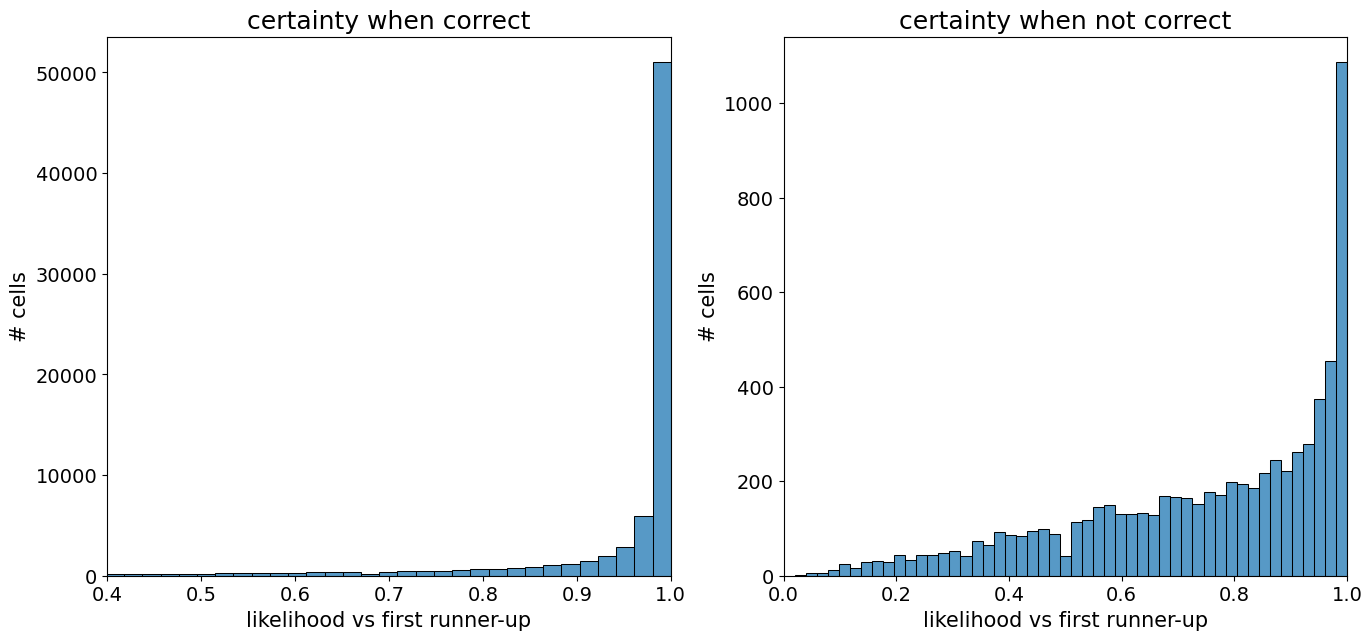

In [18]:

fig, ax = plt.subplots(1,2, figsize = (16,7))
sns.histplot(preds[preds.CellType == preds.scpred_no_rejection].scpred_max, ax = ax[0], bins = 50)
sns.histplot(preds[preds.CellType != preds.scpred_no_rejection].scpred_max, ax = ax[1], bins = 50)
#sns.histplot(preds[preds.actual_ct == preds.label].overall_likelihood, ax = ax[0], bins = 40)
#sns.histplot(preds[preds.actual_ct != preds.label].overall_likelihood, ax = ax[1], bins = 40)

ax[0].set_ylabel('# cells', fontsize = 15)
ax[1].set_ylabel('# cells', fontsize = 15)

ax[0].set_xlabel('likelihood vs first runner-up', fontsize = 15)
ax[1].set_xlabel('likelihood vs first runner-up', fontsize = 15)

ax[0].set_title('certainty when correct', fontsize = 18)
ax[1].set_title('certainty when not correct', fontsize = 18)

ax[0].set_xlim(0.4,1)
ax[1].set_xlim(0,1)

ax[0].set_xticklabels(ax[0].get_xticklabels(), size = 14)
ax[1].set_xticklabels(ax[1].get_xticklabels(), size = 14)

ax[0].set_yticklabels(ax[0].get_yticklabels(), size = 14)
ax[1].set_yticklabels(ax[1].get_yticklabels(), size = 14)

#plt.savefig('ExtFigure3_scPRED_histogram_certainty_whencorrectvsnot.svg', format = 'svg', dpi = 200)

## Extended Figure 4b and c: Memory consumtion of classification and training models

Text(0.5, 0, 'Minutes')

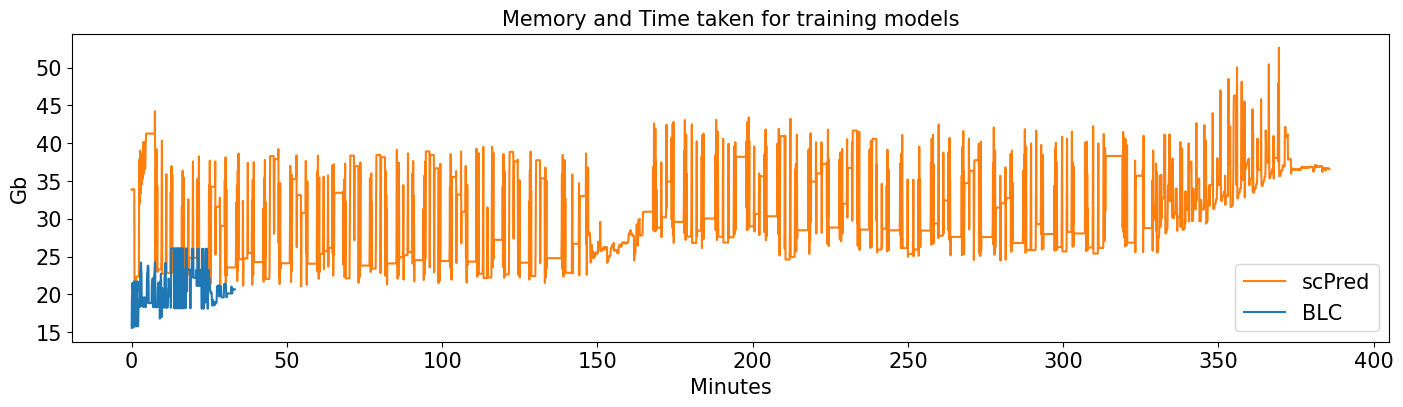

In [52]:
#fig, ax = plt.subplots(figsize = (17,4))
plt.figure(figsize = (17,4))


scpred_memory = np.load('../../computational_resources_arrays/scPRED_TRAIN_memory_usage_rawFrompsutils.npy')
scpred_memory = [(x/(1024**2))*0.001 for x in scpred_memory]
# Time array in seconds, 5 seconds interval and starting from 0
time_seconds = np.arange(0, len(scpred_memory) * 5, 5)
# Convert time to hours for x-axis
time_minutes = time_seconds / 60
# Create a line plot
sns.lineplot(x=time_minutes, y=scpred_memory, label = 'scPred', color = 'tab:orange')

blc = np.load('../../computational_resources_arrays/BLC_TRAIN_memory_usage_rawFrompsutils.npy')
blc = [(x/(1024**2))*0.001 for x in blc]
# Time array in seconds, 5 seconds interval and starting from 0
time_seconds = np.arange(0, len(blc) * 5, 5)
# Convert time to hours for x-axis
time_minutes = time_seconds / 60
# Create a line plot
sns.lineplot(x=time_minutes, y=blc, label = 'BLC', color = 'tab:blue')

plt.legend(prop={'size':15})
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.title('Memory and Time taken for training models', fontsize = 15)
plt.ylabel('Gb', fontsize = 15)
plt.xlabel('Minutes', fontsize = 15)

#plt.savefig('ExtFig_MemoryAndTime.svg', dpi = 200, format = 'svg', bbox_inches = 'tight')

In [49]:
blc = np.load('../../computational_resources_arrays/BLC_TEST_memory_usage_GB.npy')
scpred = np.load('../../computational_resources_arrays/scPREDcells_TEST_memory_usage_GB.npy')
sctype = np.load('../../computational_resources_arrays/scTypecells_TEST_memory_usage_GB.npy')


In [50]:
allmeans = pd.DataFrame({'BLC':np.mean(blc), 'scPred':np.mean(scpred), 'scType':np.mean(sctype)}, index = [0])

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 [Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5'),
  Text(0, 20.0, '20.0'),
  Text(0, 22.5, '22.5')])

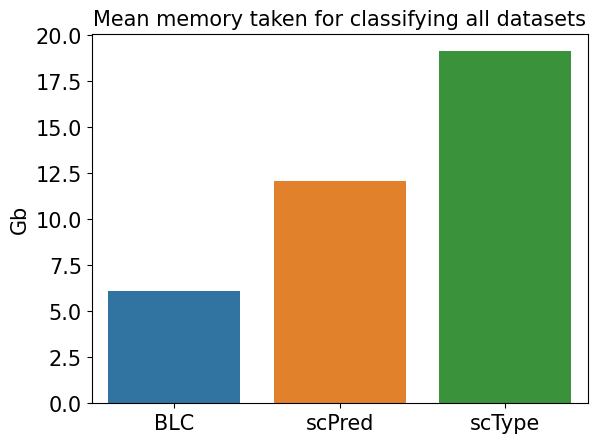

In [51]:
sns.barplot(allmeans)
plt.title('Mean memory taken for classifying all datasets', fontsize = 15)
plt.ylabel('Gb', fontsize = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
#plt.savefig('ExtFig_MemoryCLASSIFICATION.svg', dpi = 200, format = 'svg', bbox_inches = 'tight')

# Extended Figure 5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


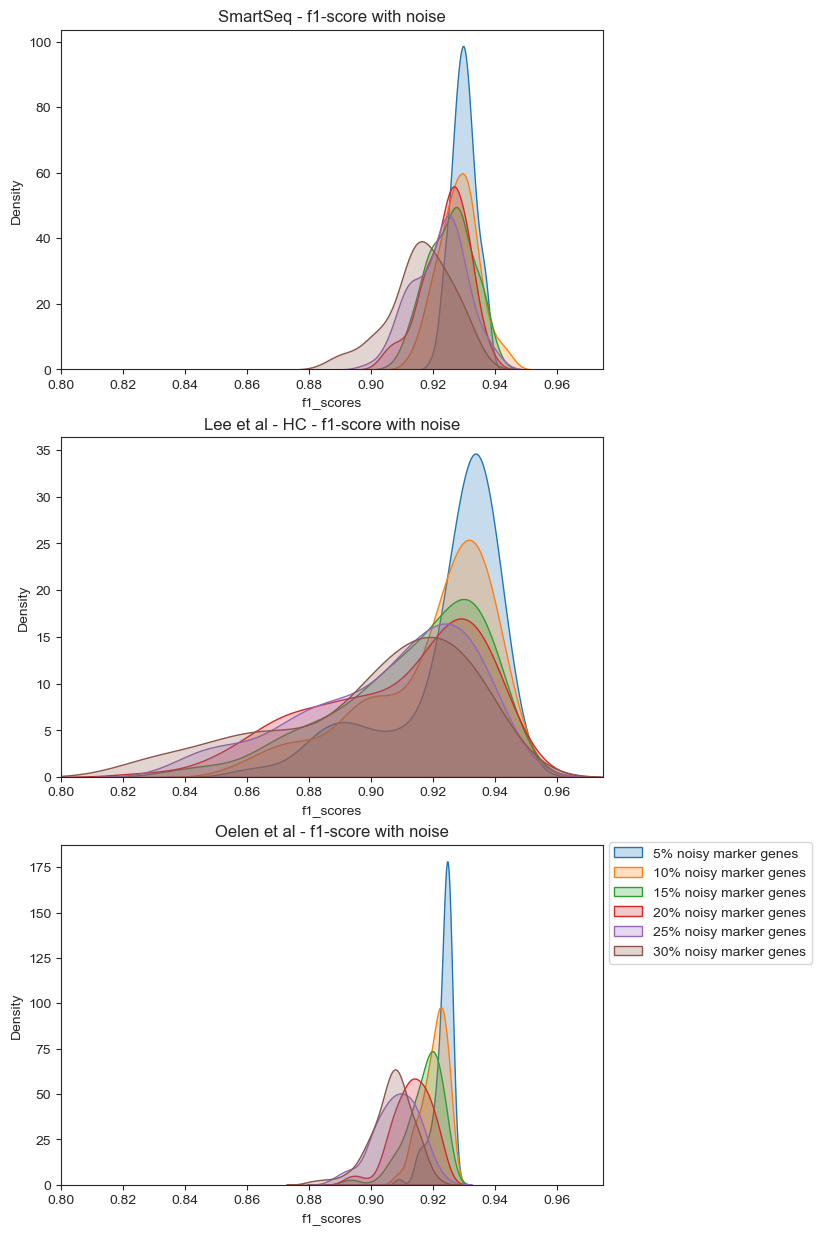

In [ ]:
#Smartseq
shufg_ss = pd.read_csv('/Users/rikardforlin/Forskning/EMD_annotationmodel/BLC_publication_ScriptsAndNotebooks/classifiers_results/noisy_genes/addednoise_lambda1SmartSeq3_PBMCs.csv')

#Lee HC
shufg_hc = pd.read_csv('/Users/rikardforlin/Forskning/EMD_annotationmodel/BLC_publication_ScriptsAndNotebooks/classifiers_results/noisy_genes/addednoise_lambda1Lee_et_al_Science_HConly.csv')

#EGAD:
shufg_egad = pd.read_csv('/Users/rikardforlin/Forskning/EMD_annotationmodel/BLC_publication_ScriptsAndNotebooks/classifiers_results/noisy_genes/addednoise_lambda1egad_3hTBAll.csv')


fig, ax = plt.subplots(3,1, figsize = (7,15))
dat_names = ['SmartSeq', 'Lee et al - HC', 'Oelen et al']
for i, dat_noise in enumerate([shufg_ss, shufg_hc, shufg_egad]):
    opf = dat_noise[dat_noise.perc_withaddednoise == 0.05]
    opo = dat_noise[dat_noise.perc_withaddednoise == 0.1]
    opfif = dat_noise[dat_noise.perc_withaddednoise == 0.15]
    opt = dat_noise[dat_noise.perc_withaddednoise == 0.2]
    optf = dat_noise[dat_noise.perc_withaddednoise == 0.25]
    opth = dat_noise[dat_noise.perc_withaddednoise == 0.3]

    sns.kdeplot(opf.f1_scores, fill = True, label = '5% noisy marker genes', ax = ax[i])
    sns.kdeplot(opo.f1_scores, fill = True, label = '10% noisy marker genes', ax = ax[i])
    sns.kdeplot(opfif.f1_scores, fill = True, label = '15% noisy marker genes', ax = ax[i])
    sns.kdeplot(opt.f1_scores, fill = True, label = '20% noisy marker genes', ax = ax[i])
    sns.kdeplot(optf.f1_scores, fill = True, label = '25% noisy marker genes', ax = ax[i])
    sns.kdeplot(opth.f1_scores, fill = True, label = '30% noisy marker genes', ax = ax[i])
    plt.legend(loc = [1.01, 0.65])
    ax[i].set_title(dat_names[i] + ' - f1-score with noise')
    ax[i].set_xlim(0.8, 0.975)
    #plt.savefig('LeeCov_deleted_genes.svg', bbox_inches = 'tight', format = 'svg', dpi = 200)
    
plt.legend(loc = [1.01, 0.65])    
#plt.savefig('noisy_genes_rest.svg', dpi = 200, bbox_inches = 'tight', format = 'svg')

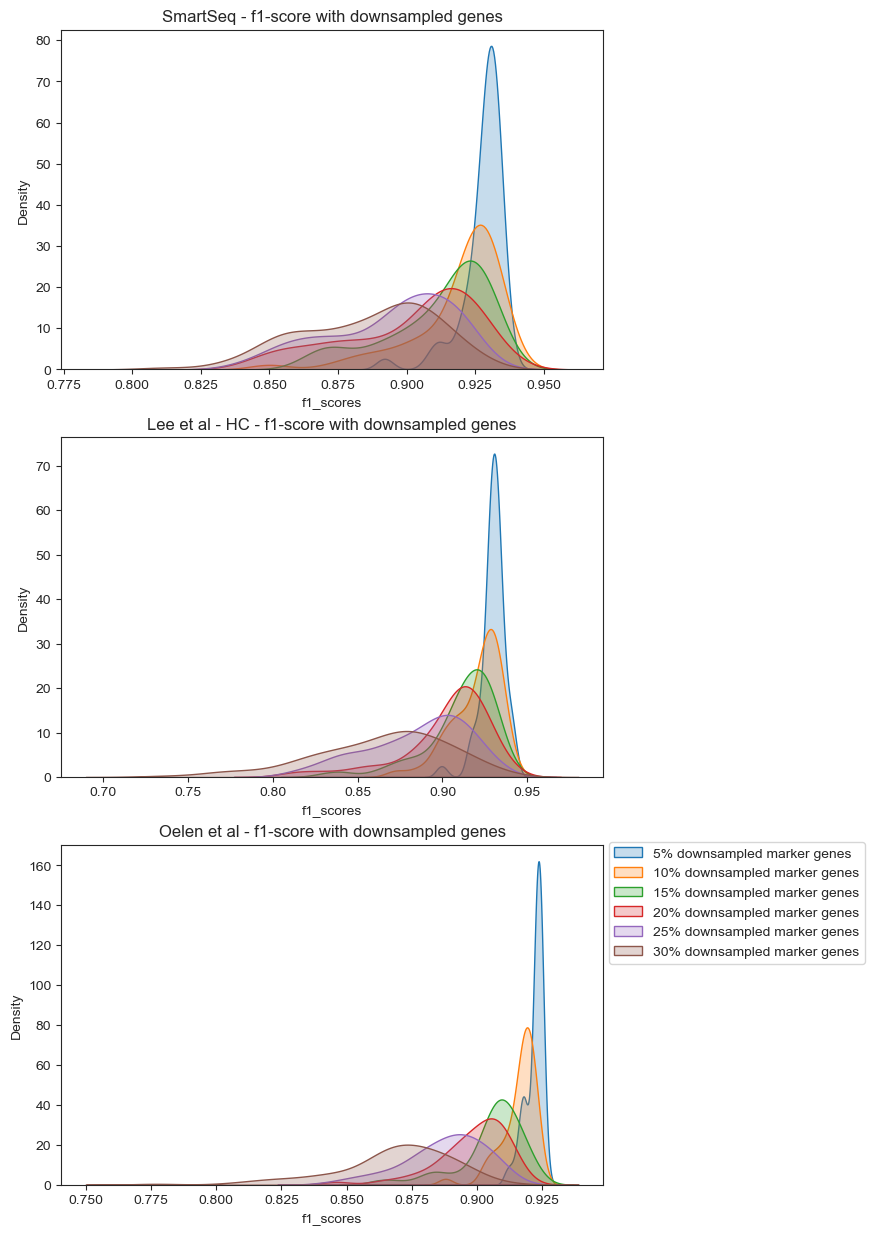

In [52]:
#Smartseq
shufg_ss = pd.read_csv('/Users/rikardforlin/Forskning/EMD_annotationmodel/BLC_publication_ScriptsAndNotebooks/classifiers_results/downsampled_genes/deleted_genesSmartSeq3_PBMCs.csv')

#Lee HC
shufg_hc = pd.read_csv('/Users/rikardforlin/Forskning/EMD_annotationmodel/BLC_publication_ScriptsAndNotebooks/classifiers_results/downsampled_genes/deleted_genesLee_et_al_Science_HConly.csv')

#Lee Covid
#shufg = pd.read_csv('/Users/rikardforlin/Forskning/EMD_annotationmodel/BLC_publication_ScriptsAndNotebooks/classifiers_results/noisy_genes/addednoise_lambda1Lee_et_al_Science_Covidonly.csv') #shown in Figure 4

#EGAD:
shufg_egad = pd.read_csv('/Users/rikardforlin/Forskning/EMD_annotationmodel/BLC_publication_ScriptsAndNotebooks/classifiers_results/downsampled_genes/deleted_genesegad_3hTBAll.csv')


fig, ax = plt.subplots(3,1, figsize = (7,15))
dat_names = ['SmartSeq', 'Lee et al - HC', 'Oelen et al']

for i, dat_downs in enumerate([shufg_ss, shufg_hc, shufg_egad]):
    opf = dat_downs[dat_downs.perc_deleted == 0.05]
    opo = dat_downs[dat_downs.perc_deleted == 0.1]
    opfif = dat_downs[dat_downs.perc_deleted == 0.15]
    opt = dat_downs[dat_downs.perc_deleted == 0.2]
    optf = dat_downs[dat_downs.perc_deleted == 0.25]
    opth = dat_downs[dat_downs.perc_deleted == 0.3]

    sns.kdeplot(opf.f1_scores, fill = True, label = '5% downsampled marker genes', ax = ax[i])
    sns.kdeplot(opo.f1_scores, fill = True, label = '10% downsampled marker genes', ax = ax[i])
    sns.kdeplot(opfif.f1_scores, fill = True, label = '15% downsampled marker genes', ax = ax[i])
    sns.kdeplot(opt.f1_scores, fill = True, label = '20% downsampled marker genes', ax = ax[i])
    sns.kdeplot(optf.f1_scores, fill = True, label = '25% downsampled marker genes', ax = ax[i])
    sns.kdeplot(opth.f1_scores, fill = True, label = '30% downsampled marker genes', ax = ax[i])
#    plt.legend(loc = [1.01, 0.65])
#    ax[i].set_title('Lee Covid - f1-score with downsampled genes')
#    ax[i].set_xlim(0.5, 0.975)
    #plt.savefig('LeeCov_deleted_genes.svg', bbox_inches = 'tight', format = 'svg', dpi = 200)
    ax[i].set_title(dat_names[i] + ' - f1-score with downsampled genes')
#    ax[i].set_xlim(0.8, 0.975)
    #plt.savefig('LeeCov_deleted_genes.svg', bbox_inches = 'tight', format = 'svg', dpi = 200)
    
plt.legend(loc = [1.01, 0.65])    
#plt.savefig('downsampled_genes_rest.svg', dpi = 200, bbox_inches = 'tight', format = 'svg')
    
    

# Extended Figure 6 - example of EMD

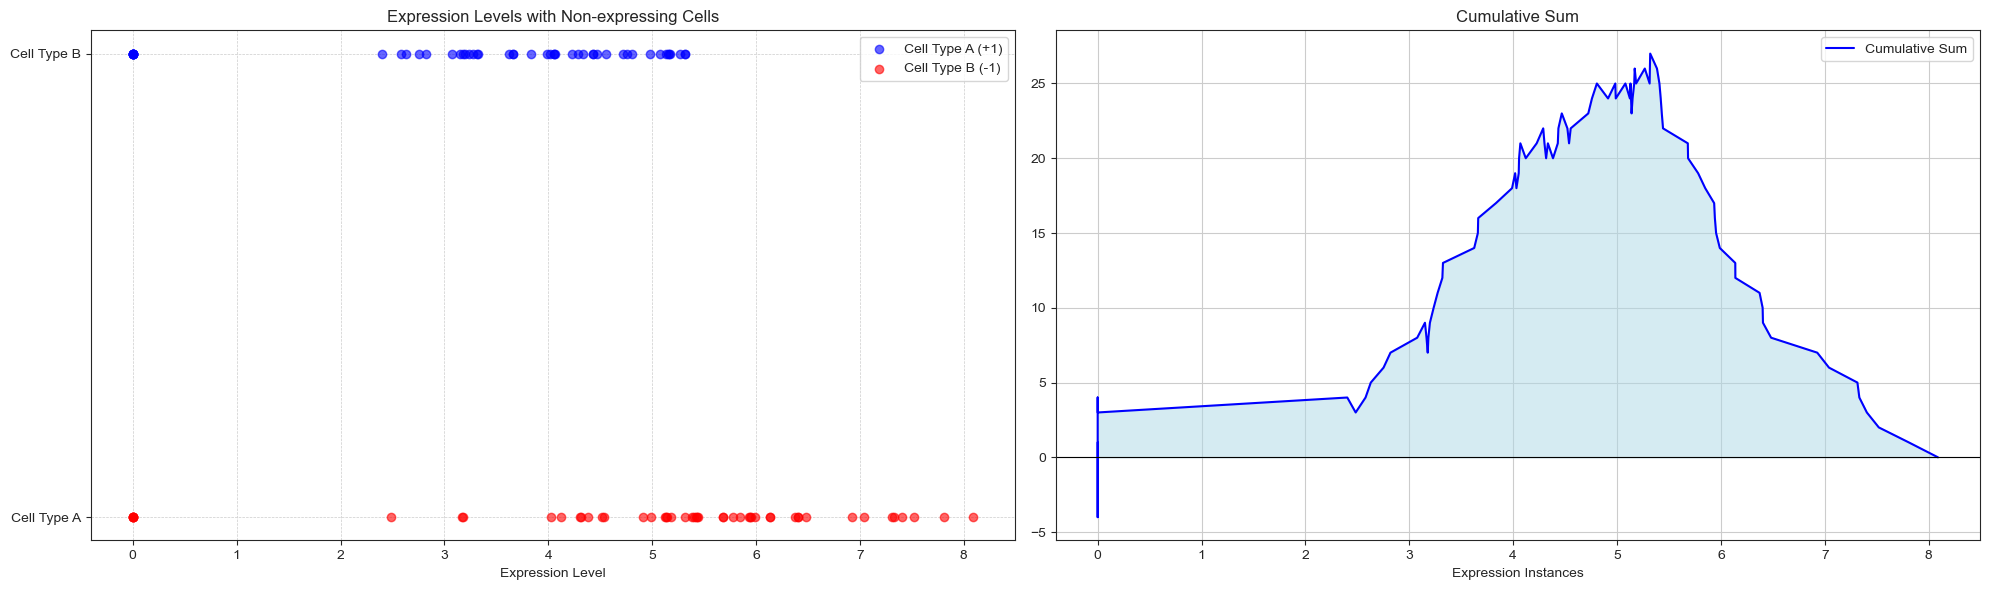

In [91]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(35)
tot_cells = 50
max_num_zeros = 20
n_zeros_cell_type_1 = int(np.random.random()*max_num_zeros)
n_zeros_cell_type_2 = int(np.random.random()*max_num_zeros)
expression_cell_type_1 = np.random.normal(loc=4.0, scale=1, size=tot_cells-n_zeros_cell_type_1)
expression_cell_type_2 = np.random.normal(loc=5.5, scale=1, size=tot_cells-n_zeros_cell_type_2)
expression_cell_type_1_with_zeros = np.concatenate((expression_cell_type_1, np.zeros(n_zeros_cell_type_1)))
expression_cell_type_2_with_zeros = np.concatenate((expression_cell_type_2, np.zeros(n_zeros_cell_type_2)))
combined_expressions_with_zeros = np.sort(np.concatenate((expression_cell_type_1_with_zeros, expression_cell_type_2_with_zeros)))
values_with_zeros = np.concatenate((np.ones(tot_cells), -1 * np.ones(tot_cells)))[np.argsort(np.concatenate((expression_cell_type_1_with_zeros, expression_cell_type_2_with_zeros)))]
cumulative_sum_with_zeros = np.cumsum(values_with_zeros)
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].scatter(expression_cell_type_1_with_zeros, np.ones(tot_cells), color='blue', alpha=0.6, label='Cell Type A (+1)')
axs[0].scatter(expression_cell_type_2_with_zeros, -1 * np.ones(tot_cells), color='red', alpha=0.6, label='Cell Type B (-1)')
axs[0].set_title('Expression Levels with Non-expressing Cells')
axs[0].set_xlabel('Expression Level')
axs[0].set_yticks([-1, 1])
axs[0].set_yticklabels(['Cell Type A', 'Cell Type B'])
axs[0].legend()
axs[0].grid(True, which='major', linestyle='--', linewidth=0.5)
axs[1].plot(combined_expressions_with_zeros, cumulative_sum_with_zeros, label='Cumulative Sum', color='blue')
axs[1].fill_between(combined_expressions_with_zeros, 0, cumulative_sum_with_zeros, color='lightblue', alpha=0.5)
axs[1].axhline(0, color='black', lw=0.8)  # X-axis
axs[1].set_title('Cumulative Sum')
axs[1].set_xlabel('Expression Instances')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
#plt.show()

#plt.savefig('EMD_example_highEMDdistance.svg', dpi = 200, bbox_inches = 'tight', format = 'svg')

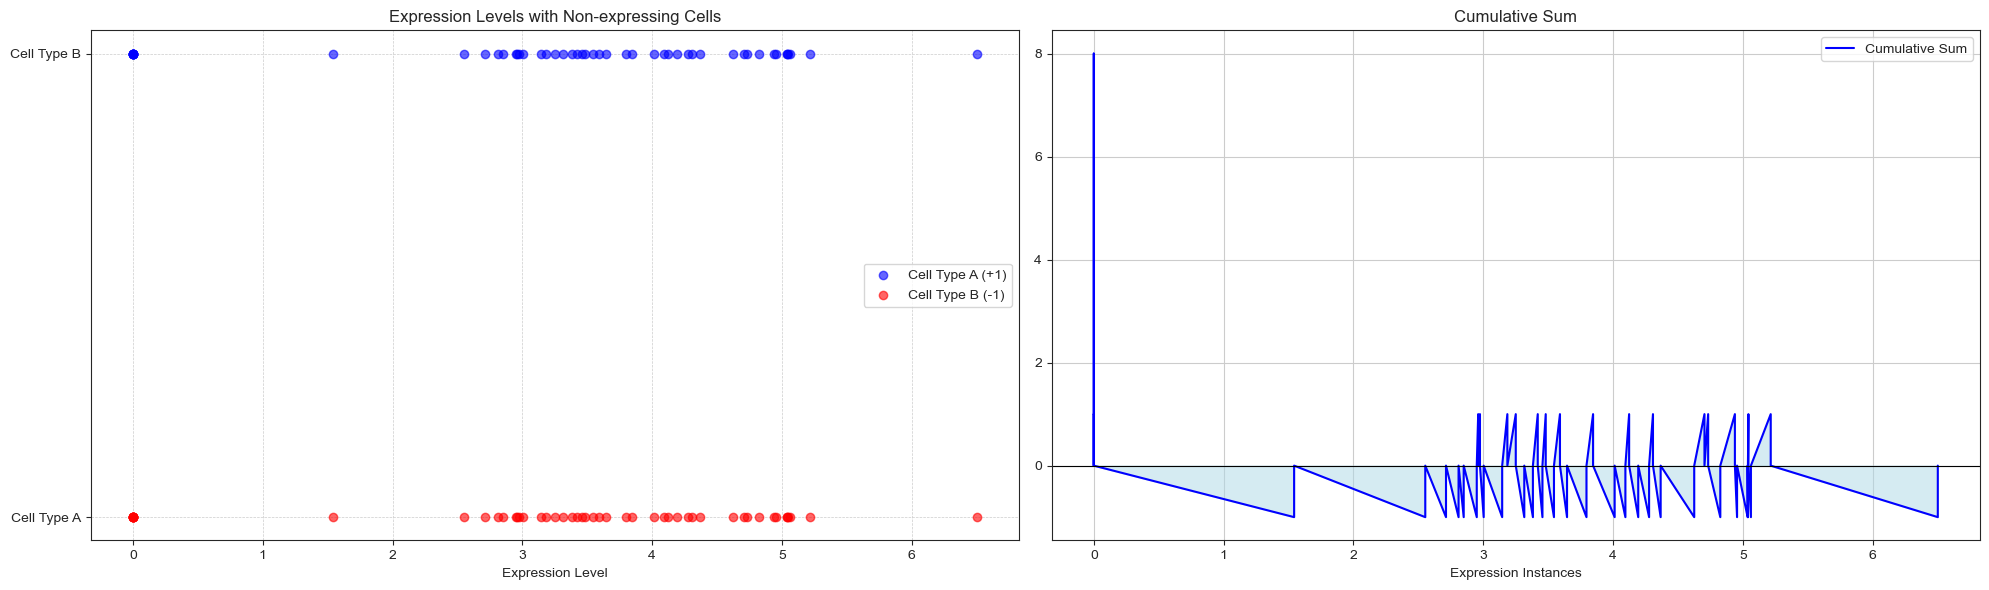

In [92]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(35)
tot_cells = 50
max_num_zeros = 20
n_zeros_cell_type_1 = int(np.random.random()*max_num_zeros)
n_zeros_cell_type_2 = n_zeros_cell_type_1
#n_zeros_cell_type_2 = int(np.random.random()*max_num_zeros)
expression_cell_type_1 = np.random.normal(loc=4.0, scale=1, size=tot_cells-n_zeros_cell_type_1)
#expression_cell_type_2 = np.random.normal(loc=4.0, scale=1, size=tot_cells-n_zeros_cell_type_2)
expression_cell_type_2 = expression_cell_type_1#np.random.normal(loc=4.0, scale=1, size=tot_cells-n_zeros_cell_type_2)

expression_cell_type_1_with_zeros = np.concatenate((expression_cell_type_1, np.zeros(n_zeros_cell_type_1)))
expression_cell_type_2_with_zeros = np.concatenate((expression_cell_type_2, np.zeros(n_zeros_cell_type_2)))
combined_expressions_with_zeros = np.sort(np.concatenate((expression_cell_type_1_with_zeros, expression_cell_type_2_with_zeros)))
values_with_zeros = np.concatenate((np.ones(tot_cells), -1 * np.ones(tot_cells)))[np.argsort(np.concatenate((expression_cell_type_1_with_zeros, expression_cell_type_2_with_zeros)))]
cumulative_sum_with_zeros = np.cumsum(values_with_zeros)
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].scatter(expression_cell_type_1_with_zeros, np.ones(tot_cells), color='blue', alpha=0.6, label='Cell Type A (+1)')
axs[0].scatter(expression_cell_type_2_with_zeros, -1 * np.ones(tot_cells), color='red', alpha=0.6, label='Cell Type B (-1)')
axs[0].set_title('Expression Levels with Non-expressing Cells')
axs[0].set_xlabel('Expression Level')
axs[0].set_yticks([-1, 1])
axs[0].set_yticklabels(['Cell Type A', 'Cell Type B'])
axs[0].legend()
axs[0].grid(True, which='major', linestyle='--', linewidth=0.5)
axs[1].plot(combined_expressions_with_zeros, cumulative_sum_with_zeros, label='Cumulative Sum', color='blue')
axs[1].fill_between(combined_expressions_with_zeros, 0, cumulative_sum_with_zeros, color='lightblue', alpha=0.5)
axs[1].axhline(0, color='black', lw=0.8)  # X-axis
axs[1].set_title('Cumulative Sum')
axs[1].set_xlabel('Expression Instances')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
#plt.show()

#plt.savefig('EMD_example_lowEMDdistance.svg', dpi = 200, bbox_inches = 'tight', format = 'svg')